In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
import nltk 
from nltk.corpus import stopwords
import tqdm
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter


# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Philip Fowler

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [5]:
# This is how the data was downloaded using the Kaggle API
# The data is already in the data folder, thus, it is now commented out
# The most challenging part was to install the Kaggle API and to set up the API key 
# I initially put the API key in the wrong place.  usr/bin/kaggle.json is the correct location  

# import kagglehub
# import shutil
# import os

# Download latest version
# path = kagglehub.dataset_download("austinreese/trump-tweets")

# Create data directory if it doesn't exist
# data_dir = "data"
# if not os.path.exists(data_dir):
#    os.makedirs(data_dir)

# Move downloaded files to data directory
# for file_name in os.listdir(path):
#    full_file_name = os.path.join(path, file_name)
#    if os.path.isfile(full_file_name):
#        shutil.move(full_file_name, data_dir)

# print("Files have been moved to the data folder.")

In [6]:
# Load the CSV file into a dataframe
df_trump_tweets = pd.read_csv('data/realdonaldtrump.csv')
print(df_trump_tweets.head())

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  
0       510        917      NaN      NaN  
1        34        267      NaN      NaN  

In [7]:
# Select the columns 'content' and 'date' from the dataframe
df_content_date = df_trump_tweets[['content', 'date']]

# Save the selected columns to an HTML file
df_content_date.to_html('trumptweets.html', index=False)

2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [8]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply the function to the 'content' column and create a new column 'vader_sentiment'
df_trump_tweets['vader_sentiment'] = df_trump_tweets['content'].apply(get_vader_sentiment)

# Display the DataFrame
print(df_trump_tweets[['content', 'vader_sentiment']].head())
print(df_trump_tweets[['content', 'vader_sentiment']].tail())


                                             content  vader_sentiment
0  Be sure to tune in and watch Donald Trump on L...           0.5255
1  Donald Trump will be appearing on The View tom...           0.7712
2  Donald Trump reads Top Ten Financial Tips on L...           0.6468
3  New Blog Post: Celebrity Apprentice Finale and...           0.0000
4  "My persona will never be that of a wallflower...           0.0000
                                                 content  vader_sentiment
43347  Joe Biden was a TOTAL FAILURE in Government. H...          -0.7469
43348  Will be interviewed on @ seanhannity tonight a...           0.5411
43349                         pic.twitter.com/3lm1spbU8X           0.0000
43350                         pic.twitter.com/vpCE5MadUz           0.0000
43351                         pic.twitter.com/VLlc0BHW41           0.0000


In [9]:
# There is no point analyzing the rows that contain pic.twitter.com  can't do much with that.
# Count the number of rows containing 'pic.twitter.com'
count = df_trump_tweets['content'].str.contains('pic.twitter.com').sum()

print(f"Number of rows containing 'pic.twitter.com': {count}")

Number of rows containing 'pic.twitter.com': 3685


In [10]:
#let's delete the rows containing 'pic.twitter.com'
df_trump_tweets = df_trump_tweets[~df_trump_tweets['content'].str.contains('pic.twitter.com')]  

count = df_trump_tweets['content'].str.contains('pic.twitter.com').sum()
print(f"Number of rows containing 'pic.twitter.com': {count}")
print(df_trump_tweets.info())

Number of rows containing 'pic.twitter.com': 0
<class 'pandas.core.frame.DataFrame'>
Index: 39667 entries, 0 to 43348
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               39667 non-null  int64  
 1   link             39667 non-null  object 
 2   content          39667 non-null  object 
 3   date             39667 non-null  object 
 4   retweets         39667 non-null  int64  
 5   favorites        39667 non-null  int64  
 6   mentions         19216 non-null  object 
 7   hashtags         4116 non-null   object 
 8   vader_sentiment  39667 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 3.0+ MB
None


3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [11]:
# Load the English model
nlp = spacy.load('en_core_web_sm')

# Concatenate all text in the 'content' column
all_text = ' '.join(df_trump_tweets['content'].astype(str).tolist())

# Check the length of the text
text_length = len(all_text)
print(f"Text length: {text_length}")

# Increase the max_length limit
nlp.max_length = text_length + 1000  # Adding a buffer to the length

# Process the text with spacy
doc = nlp(all_text)

# Extract tokens, convert to lower case, and filter out stop words and punctuation
tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]

# Get the five most common tokens
token_freq = Counter(tokens).most_common(5)

# Print the five most common tokens and their frequencies
for token, freq in token_freq:
    print(f"Token: {token}, Frequency: {freq}")

Text length: 5272985
Token: realdonaldtrump, Frequency: 8402
Token: great, Frequency: 6033
Token: trump, Frequency: 5541
Token: president, Frequency: 2851
Token: people, Frequency: 2568


4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [12]:
# Load the English model
nlp = spacy.load('en_core_web_sm')

# Concatenate all text in the 'content' column
all_text = ' '.join(df_trump_tweets['content'].astype(str).tolist())

# Check the length of the text
text_length = len(all_text)
print(f"Text length: {text_length}")

# Increase the max_length limit
nlp.max_length = text_length + 1000  # Adding a buffer to the length

# Process the text with spacy
doc = nlp(all_text)

# Extract lemmas, convert to lower case, and filter out stop words and punctuation
lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

# Get the five most common lemmas
lemma_freq = Counter(lemmas).most_common(5)

# Print the five most common lemmas and their frequencies
for lemma, freq in lemma_freq:
    print(f"Lemma: {lemma}, Frequency: {freq}")

Text length: 5272985
Lemma: realdonaldtrump, Frequency: 8402
Lemma: great, Frequency: 6342
Lemma: trump, Frequency: 5575
Lemma: thank, Frequency: 4149
Lemma: president, Frequency: 2907


5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the English model
nlp = spacy.load('en_core_web_sm')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score for a given text using tokens
def get_token_score(text):
    doc = nlp(text)
    token_scores = [analyzer.polarity_scores(token.text)['compound'] for token in doc if not token.is_stop and not token.is_punct]
    return sum(token_scores) / len(token_scores) if token_scores else 0

# Function to calculate sentiment score for a given text using lemmas
def get_lemma_score(text):
    doc = nlp(text)
    lemma_scores = [analyzer.polarity_scores(token.lemma_)['compound'] for token in doc if not token.is_stop and not token.is_punct]
    return sum(lemma_scores) / len(lemma_scores) if lemma_scores else 0

# Apply the functions to the 'content' column and create new columns 'token_score' and 'lemma_score'
df_trump_tweets['token_score'] = df_trump_tweets['content'].apply(get_token_score)
df_trump_tweets['lemma_score'] = df_trump_tweets['content'].apply(get_lemma_score)

# Display the DataFrame with the new columns
print(df_trump_tweets[['content', 'token_score', 'lemma_score']].head())

                                             content  token_score  lemma_score
0  Be sure to tune in and watch Donald Trump on L...     0.026517     0.026517
1  Donald Trump will be appearing on The View tom...     0.068614     0.068614
2  Donald Trump reads Top Ten Financial Tips on L...     0.044040     0.044040
3  New Blog Post: Celebrity Apprentice Finale and...     0.000000     0.000000
4  "My persona will never be that of a wallflower...     0.000000     0.000000


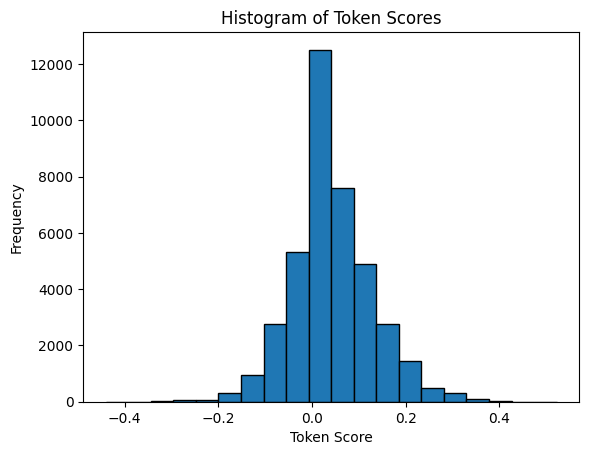

In [14]:
# Plot the histogram of the token_score column
plt.hist(df_trump_tweets['token_score'], bins=20, edgecolor='black')
plt.title('Histogram of Token Scores')
plt.xlabel('Token Score')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Calculate statistics for the 'token_score' column
mean_score = df_trump_tweets['token_score'].mean()
median_score = df_trump_tweets['token_score'].median()
mode_score = df_trump_tweets['token_score'].mode()[0]  # mode() returns a Series, take the first value
max_score = df_trump_tweets['token_score'].max()
min_score = df_trump_tweets['token_score'].min()
range_score = max_score - min_score
std_deviation_score = df_trump_tweets['token_score'].std()

# Print the statistics
print(f"Mean: {mean_score}")
print(f"Median: {median_score}")
print(f"Mode: {mode_score}")
print(f"Max: {max_score}")
print(f"Min: {min_score}")
print(f"Range: {range_score}")
print(f"Standard Deviation: {std_deviation_score}")

Mean: 0.03968927391214934
Median: 0.02848
Mode: 0.0
Max: 0.52235
Min: -0.4404
Range: 0.96275
Standard Deviation: 0.08696466991534824


6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

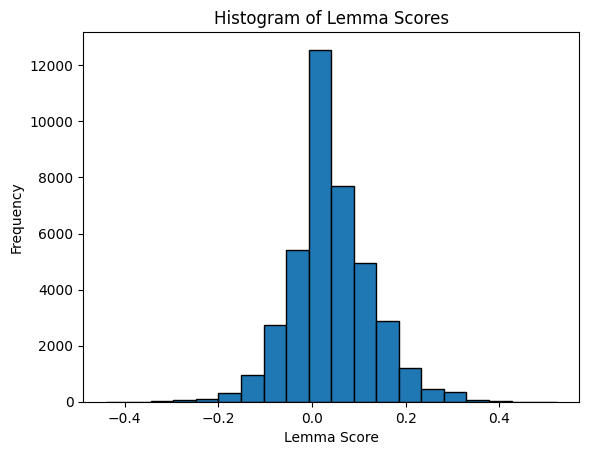

In [16]:
# Lemma score was calculated in a previous step.  No reason to recalculate here.
# Plot the histogram of the lemma_score column
plt.hist(df_trump_tweets['lemma_score'], bins=20, edgecolor='black')
plt.title('Histogram of Lemma Scores')
plt.xlabel('Lemma Score')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Calculate statistics for the 'lemma_score' column
mean_score = df_trump_tweets['lemma_score'].mean()
median_score = df_trump_tweets['lemma_score'].median()
mode_score = df_trump_tweets['lemma_score'].mode()[0]  # mode() returns a Series, take the first value
max_score = df_trump_tweets['lemma_score'].max()
min_score = df_trump_tweets['lemma_score'].min()
range_score = max_score - min_score
std_deviation_score = df_trump_tweets['lemma_score'].std()

# Print the statistics
print(f"Mean: {mean_score}")
print(f"Median: {median_score}")
print(f"Mode: {mode_score}")
print(f"Max: {max_score}")
print(f"Min: {min_score}")
print(f"Range: {range_score}")
print(f"Standard Deviation: {std_deviation_score}")

Mean: 0.0386645034520253
Median: 0.028478571428571426
Mode: 0.0
Max: 0.52235
Min: -0.4404
Range: 0.96275
Standard Deviation: 0.08541845257232926


7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): 
* Cutoff Score (lemmas):

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

The median is the value that defines the cutoff score if we want to divide the data into two equal parts.  In this case, we want to divide the data into two parts such that fewer than half the sentences would have a score greater than the cutoff score.  This means that the median is good starting point for the cutoff score.

In [18]:
# Calculate the median cutoff scores using the existing 'token_score' and 'lemma_score' columns
token_cutoff_score = df_trump_tweets['token_score'].median()
lemma_cutoff_score = df_trump_tweets['lemma_score'].median()

# Print the cutoff scores
print(f"Token Cutoff Score: {token_cutoff_score}")
print(f"Lemma Cutoff Score: {lemma_cutoff_score}")

Token Cutoff Score: 0.02848
Lemma Cutoff Score: 0.028478571428571426


8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

Creating a summary of the 40 thousand trump tweets seemed like a daunting task, so I decided to summarize each month's tweets.  The cell below is meant to create the summaries for each month.  Each summary is expected to be 1-2 sentences in length.  I will apply the cutoff scores to the summaries that are created after all of the summaries are produced and the polarity scores are calculated in step 9.  I am doing this as I want to spend some time at the end doing my own exploration.  I would like summaries and scores for the whole dataset.

In [35]:
from transformers import pipeline, AutoTokenizer

# Set the device to CPU 
# When set to GPU I encountered numerous errors.  I am not sure why.  I am using a GPU
device = -1

# Specify the model to use for summarization
model_name = "sshleifer/distilbart-cnn-12-6"  # You can change this to any other model

# Initialize the summarization pipeline with the specified model and device
summarizer = pipeline("summarization", model=model_name, device=device)

# Initialize the tokenizer with the same model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to summarize text
def summarize_text(text):
    if len(text.strip()) == 0:
        return "No content to summarize"
    
    # Truncate the text to the maximum sequence length
    inputs = tokenizer(text, max_length=1024, truncation=True, return_tensors="pt")
    truncated_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
    
    # Summarize the truncated text using the transformer model
    summary = summarizer(truncated_text, max_length=31, min_length=25, do_sample=False)
    return summary[0]['summary_text']

# Ensure the 'date' column is in datetime format
df_trump_tweets['date'] = pd.to_datetime(df_trump_tweets['date'])

# Extract month and year from the 'date' column
df_trump_tweets['month'] = df_trump_tweets['date'].dt.month
df_trump_tweets['year'] = df_trump_tweets['date'].dt.year

# Group by year and month
grouped = df_trump_tweets.groupby(['year', 'month'])

# Create a new DataFrame to store the summaries
summaries = []

for (year, month), group in grouped:
    # Concatenate all text in the group
    all_text = ' '.join(group['content'].astype(str).tolist())
    if len(all_text.strip()) == 0:
        continue
    # Summarize the concatenated text
    summary = summarize_text(all_text)
    summaries.append({'year': year, 'month': month, 'summary': summary})

# Create the new DataFrame
df_trump_tweet_summaries = pd.DataFrame(summaries)

# Display the new DataFrame
print(df_trump_tweet_summaries.head())

   year  month                                            summary
0  2009      5   Donald Trump presents the Top Ten List on Lat...
1  2009      6   Today is Donald Trump's Birthday! Send him yo...
2  2009      7   "Be aware of things that seem inexplicable be...
3  2009      8   Watch Donald Trump's recent appearance on The...
4  2009      9   "A lot of people have imagination, but can't ...


9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [36]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Load the English model for sentence segmentation
nlp = spacy.load('en_core_web_sm')

# Function to calculate VADER sentiment score
def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

# Function to count the number of sentences
def count_sentences(text):
    doc = nlp(text)
    return len(list(doc.sents))

# Apply the functions to the 'summary' column and create new columns 'vader_score' and 'number_of_sentences'
df_trump_tweet_summaries['vader_score'] = df_trump_tweet_summaries['summary'].apply(get_vader_score)
df_trump_tweet_summaries['number_of_sentences'] = df_trump_tweet_summaries['summary'].apply(count_sentences)

# Display the updated DataFrame
print(df_trump_tweet_summaries.head())

   year  month                                            summary  \
0  2009      5   Donald Trump presents the Top Ten List on Lat...   
1  2009      6   Today is Donald Trump's Birthday! Send him yo...   
2  2009      7   "Be aware of things that seem inexplicable be...   
3  2009      8   Watch Donald Trump's recent appearance on The...   
4  2009      9   "A lot of people have imagination, but can't ...   

   vader_score  number_of_sentences  
0       0.2023                    2  
1       0.5848                    2  
2       0.8402                    1  
3       0.0000                    1  
4       0.0000                    2  


10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

lemmatize first and then summarize is the strategy.  Relying on GitHub Copilot to help figure this out.  Transformers does not have the ability to lemmatize. I will need to use spaCy for this task.  I will need to load the spaCy model and then lemmatize the text.  I will then need to calculate the scores for the lemmatized text.  I will then need to summarize the text based on the scores.  

In [41]:
# Initialize the spacy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Set the device to CPU
device = -1

# Specify the model to use for summarization
model_name = "sshleifer/distilbart-cnn-12-6"  # You can change this to any other model

# Initialize the summarization pipeline with the specified model and device
summarizer = pipeline("summarization", model=model_name, device=device)

# Initialize the tokenizer with the same model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Function to summarize text
def summarize_text(text):
    if len(text.strip()) == 0:
        return "No content to summarize"
    
    # Truncate the text to the maximum sequence length
    inputs = tokenizer(text, max_length=1000, truncation=True, return_tensors="pt")
    if inputs["input_ids"].size(1) == 0:
        return "No content to summarize"
    truncated_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
    
    # Summarize the truncated text using the transformer model
    summary = summarizer(truncated_text, max_length=31, min_length=25, do_sample=False)
    return summary[0]['summary_text']

# Ensure the 'date' column is in datetime format
df_trump_tweets['date'] = pd.to_datetime(df_trump_tweets['date'])

# Extract month and year from the 'date' column
df_trump_tweets['month'] = df_trump_tweets['date'].dt.month
df_trump_tweets['year'] = df_trump_tweets['date'].dt.year

# Lemmatize each tweet in the 'content' column
df_trump_tweets['lemmatized_content'] = df_trump_tweets['content'].apply(lemmatize_text)

# Group by year and month
grouped = df_trump_tweets.groupby(['year', 'month'])

# Create a list to store the lemmatized summaries
lemma_summaries = []

for (year, month), group in grouped:
    # Concatenate all lemmatized text in the group
    all_lemmatized_text = ' '.join(group['lemmatized_content'].astype(str).tolist())
    if len(all_lemmatized_text.strip()) == 0:
        continue
    # Summarize the lemmatized text
    lemma_summary = summarize_text(all_lemmatized_text)
    lemma_summaries.append({'year': year, 'month': month, 'lemma_summary': lemma_summary})

# Create the new DataFrame for lemma summaries
df_lemma_summaries = pd.DataFrame(lemma_summaries)

# Merge the lemma summaries with the existing df_trump_tweet_summaries DataFrame
df_trump_tweet_summaries = pd.merge(df_trump_tweet_summaries, df_lemma_summaries, on=['year', 'month'], how='outer')

# Display the updated DataFrame
print(df_trump_tweet_summaries.head())

   year  month                                            summary  \
0  2009      5   Donald Trump presents the Top Ten List on Lat...   
1  2009      6   Today is Donald Trump's Birthday! Send him yo...   
2  2009      7   "Be aware of things that seem inexplicable be...   
3  2009      8   Watch Donald Trump's recent appearance on The...   
4  2009      9   "A lot of people have imagination, but can't ...   

   vader_score  number_of_sentences  \
0       0.2023                    2   
1       0.5848                    2   
2       0.8402                    1   
3       0.0000                    1   
4       0.0000                    2   

                                       lemma_summary  
0   Celebrity Apprentice Finale Lessons learn way...  
1   Check Donald Trump new iGoogle Showcase page ...  
2   Donald Trump back apprentice Randal Pinkett N...  
3   Watch Donald Trump recent appearance Late Dav...  
4   Hilarious DSRL video feature Donald Trump . R...  


11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [42]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Load the English model for sentence segmentation
nlp = spacy.load('en_core_web_sm')

# Function to calculate VADER sentiment score
def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

# Function to count the number of sentences
def count_sentences(text):
    doc = nlp(text)
    return len(list(doc.sents))

# Apply the functions to the 'lemma_summary' column and create new columns 'lemma_score' and 'lemma_number_of_sentences'
df_trump_tweet_summaries['lemma_score'] = df_trump_tweet_summaries['lemma_summary'].apply(get_vader_score)
df_trump_tweet_summaries['lemma_number_of_sentences'] = df_trump_tweet_summaries['lemma_summary'].apply(count_sentences)

# Display the updated DataFrame
print(df_trump_tweet_summaries.head())

   year  month                                            summary  \
0  2009      5   Donald Trump presents the Top Ten List on Lat...   
1  2009      6   Today is Donald Trump's Birthday! Send him yo...   
2  2009      7   "Be aware of things that seem inexplicable be...   
3  2009      8   Watch Donald Trump's recent appearance on The...   
4  2009      9   "A lot of people have imagination, but can't ...   

   vader_score  number_of_sentences  \
0       0.2023                    2   
1       0.5848                    2   
2       0.8402                    1   
3       0.0000                    1   
4       0.0000                    2   

                                       lemma_summary  lemma_score  \
0   Celebrity Apprentice Finale Lessons learn way...       0.0000   
1   Check Donald Trump new iGoogle Showcase page ...      -0.4767   
2   Donald Trump back apprentice Randal Pinkett N...       0.3818   
3   Watch Donald Trump recent appearance Late Dav...      -0.1531   
4   H

12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

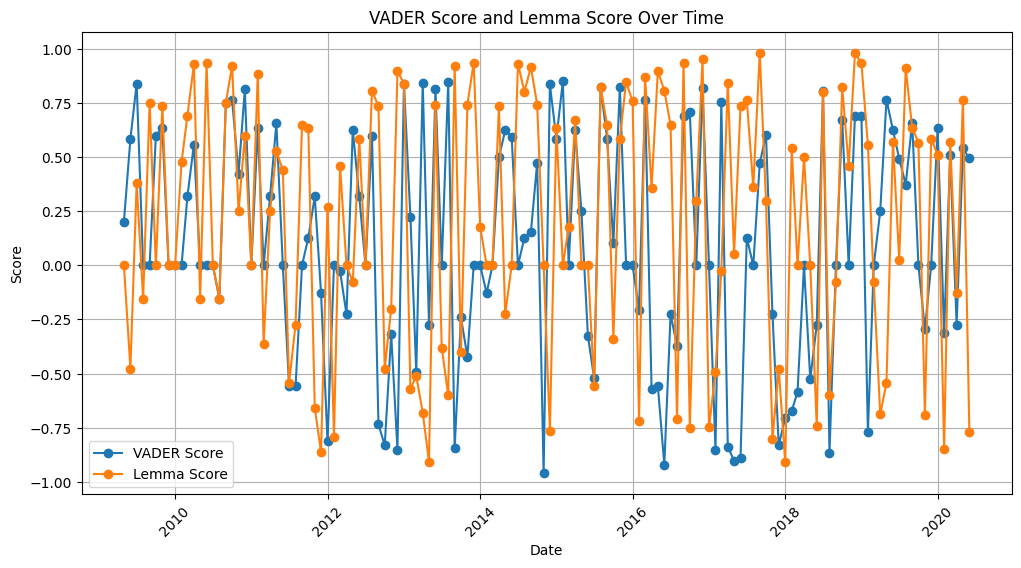

In [43]:
# Ensure the 'year' and 'month' columns are combined into a datetime column for plotting
df_trump_tweet_summaries['date'] = pd.to_datetime(df_trump_tweet_summaries[['year', 'month']].assign(day=1))

# Sort the DataFrame by date
df_trump_tweet_summaries = df_trump_tweet_summaries.sort_values('date')

# Plot the vader_score and lemma_score over time
plt.figure(figsize=(12, 6))
plt.plot(df_trump_tweet_summaries['date'], df_trump_tweet_summaries['vader_score'], label='VADER Score', marker='o')
plt.plot(df_trump_tweet_summaries['date'], df_trump_tweet_summaries['lemma_score'], label='Lemma Score', marker='o')

# Add titles and labels
plt.title('VADER Score and Lemma Score Over Time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Well that graph is definitely difficult to read.  Let's try something different.

Let's try a scatter plot for vader token score vs lemma score
An insight that I am not going to go back and fix.  I should have named vader score token score.

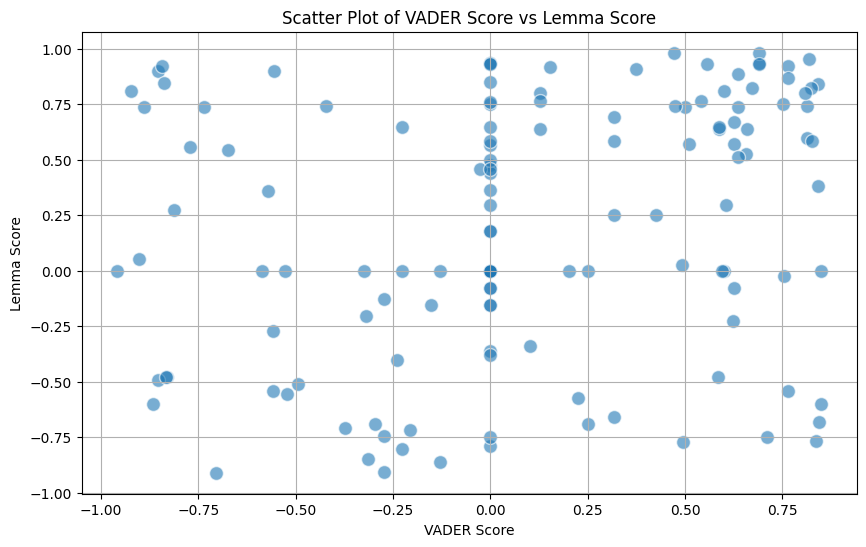

In [44]:
# Create a scatter plot comparing vader_score and lemma_score
plt.figure(figsize=(10, 6))
plt.scatter(df_trump_tweet_summaries['vader_score'], df_trump_tweet_summaries['lemma_score'], alpha=0.6, edgecolors='w', s=100)

# Add titles and labels
plt.title('Scatter Plot of VADER Score vs Lemma Score')
plt.xlabel('VADER Score')
plt.ylabel('Lemma Score')
plt.grid(True)

# Show the plot
plt.show()

well that does not help much either.  The lemma scores are quite different from the vader token score. let's go back to the time based plot and try looking at the difference between the token and lemma score for each month

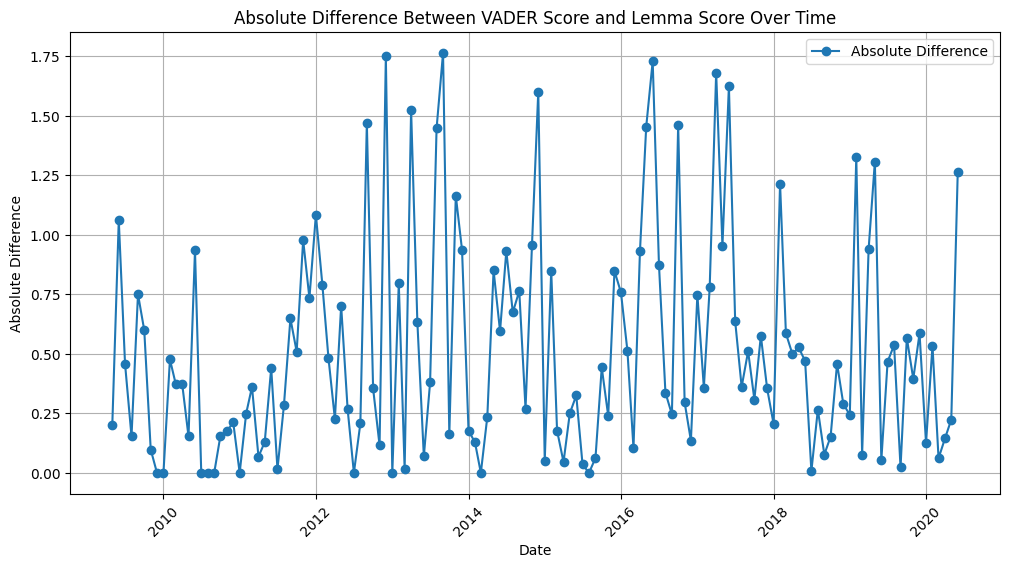

In [45]:
# Ensure the 'year' and 'month' columns are combined into a datetime column for plotting
df_trump_tweet_summaries['date'] = pd.to_datetime(df_trump_tweet_summaries[['year', 'month']].assign(day=1))

# Sort the DataFrame by date
df_trump_tweet_summaries = df_trump_tweet_summaries.sort_values('date')

# Calculate the absolute difference between vader_score and lemma_score
df_trump_tweet_summaries['abs_diff'] = (df_trump_tweet_summaries['vader_score'] - df_trump_tweet_summaries['lemma_score']).abs()

# Plot the absolute difference over time
plt.figure(figsize=(12, 6))
plt.plot(df_trump_tweet_summaries['date'], df_trump_tweet_summaries['abs_diff'], label='Absolute Difference', marker='o')

# Add titles and labels
plt.title('Absolute Difference Between VADER Score and Lemma Score Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Difference')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Well that is not very helpful either.  There are definite differences in the scores.  Before I answer question 13, I am going to do some more exploration.  I am not very confident that there is much value in the summarizing of trumps tweets by month.  I suspect that that is the source of the wildly different values above.  I purposefully kept the Trump Tweets dataframe separate from the summary dataframe so I could examine the trump tweets in other ways.  Let's go back to the trump tweets dataframe.  Here's the first few rows again in case you forgot.

In [46]:
print(df_trump_tweets.head())

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                date  \
0  Be sure to tune in and watch Donald Trump on L... 2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom... 2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L... 2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and... 2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower... 2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  vader_sentiment  token_score  \
0       510        917      NaN      NaN           0.5255   

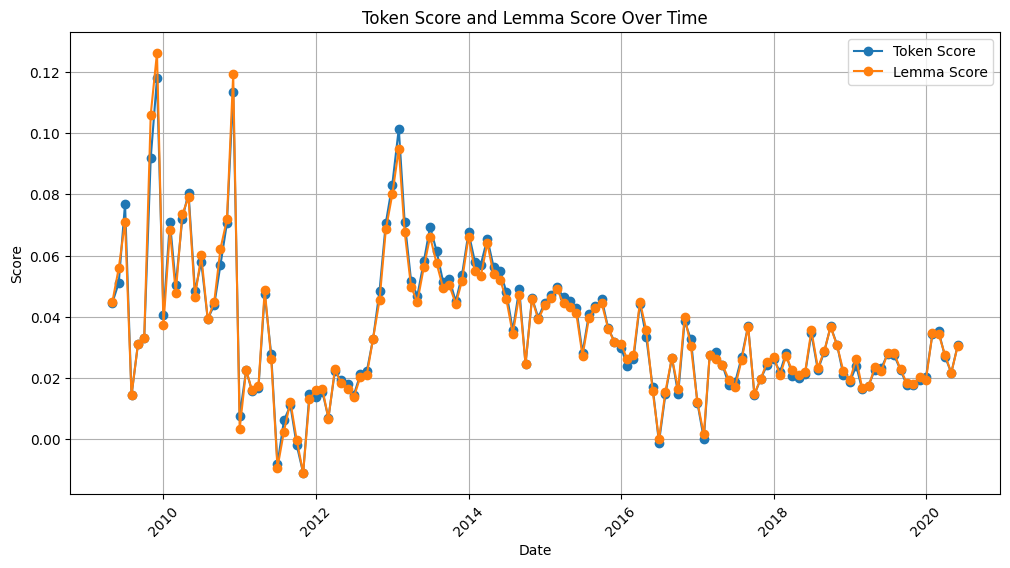

In [47]:
# Ensure the 'date' column is in datetime format
df_trump_tweets['date'] = pd.to_datetime(df_trump_tweets['date'])

# Extract month and year from the 'date' column
df_trump_tweets['month'] = df_trump_tweets['date'].dt.month
df_trump_tweets['year'] = df_trump_tweets['date'].dt.year

# Group by year and month and calculate the average token_score and lemma_score
monthly_scores = df_trump_tweets.groupby(['year', 'month']).agg({
    'token_score': 'mean',
    'lemma_score': 'mean'
}).reset_index()

# Combine the 'year' and 'month' columns into a single 'date' column for plotting
monthly_scores['date'] = pd.to_datetime(monthly_scores[['year', 'month']].assign(day=1))

# Sort the DataFrame by date
monthly_scores = monthly_scores.sort_values('date')

# Plot the token_score and lemma_score over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_scores['date'], monthly_scores['token_score'], label='Token Score', marker='o')
plt.plot(monthly_scores['date'], monthly_scores['lemma_score'], label='Lemma Score', marker='o')

# Add titles and labels
plt.title('Token Score and Lemma Score Over Time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

This plot is calculating the mean of the vader token score and the vader lemma score for each month. The plot above meets my expectations that the scores should not differ markedly.  Thus, I suspect that something went wrong with the summarizing process.  

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

I am not sure if I can answer this question.  I am not sure if the summaries are of any value.  Creating the summaries seemed to create data that yielded no value.  The token and lemma scores from the original data were of more value.  However, I cannot make a determination of whether the lemma approach or the token is approach is superior.  

I suspect that the problem with summarizing this data is that the tweets in the initial dataset are of numerous different topics.  The tweets span from when Trump had his own reality show until Biden's election.  Thus, the summaries from the tokens and the lemmas can result in very different results.  I suspect that the summaries would be more useful if the tweets were grouped by topic.  I wonder how transformer would classify the tweets.  I'll keep that in the back of my mind for future exploration.  

Now, I have a few things that I want to explore using the original data.  I am curious about whether the content of the dataset can show a correlation with whether the tweet will be retweeted. 

let's start by dropping the columns that are not needed

In [48]:
# Make a copy of the df_trump_tweets DataFrame
df_trump_tweets_predict = df_trump_tweets.copy()

# Drop the specified columns from the new DataFrame
columns_to_drop = ['id', 'link', 'month', 'year', 'lemmatized_content', 'mentions', 'hashtags', 'content']
df_trump_tweets_predict = df_trump_tweets_predict.drop(columns=columns_to_drop)

# Display the new DataFrame
print(df_trump_tweets_predict.head())

                 date  retweets  favorites  vader_sentiment  token_score  \
0 2009-05-04 13:54:25       510        917           0.5255     0.026517   
1 2009-05-04 20:00:10        34        267           0.7712     0.068614   
2 2009-05-08 08:38:08        13         19           0.6468     0.044040   
3 2009-05-08 15:40:15        11         26           0.0000     0.000000   
4 2009-05-12 09:07:28      1375       1945           0.0000     0.000000   

   lemma_score  
0     0.026517  
1     0.068614  
2     0.044040  
3     0.000000  
4     0.000000  


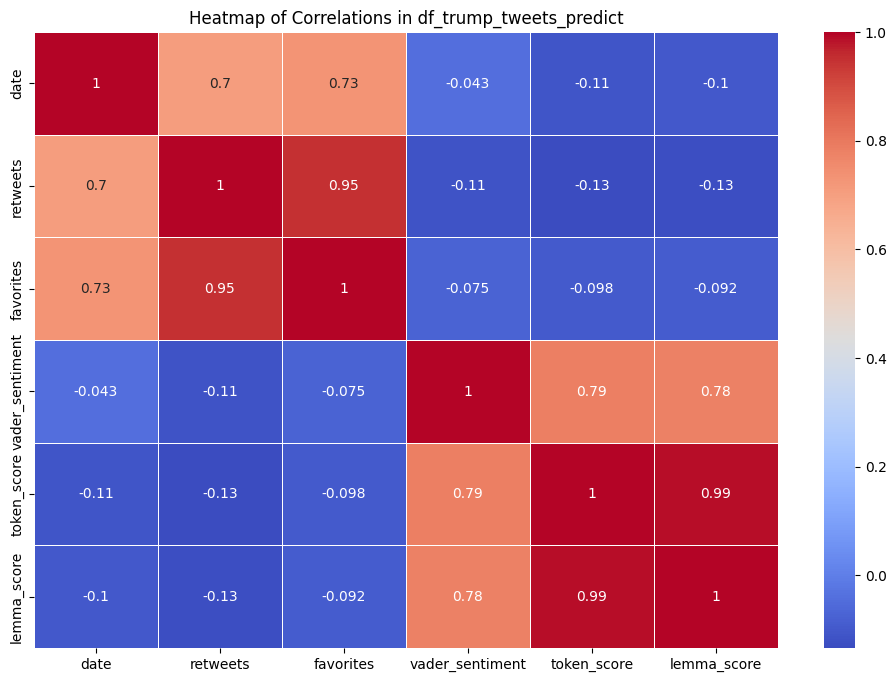

In [49]:

# Calculate the correlation matrix
correlation_matrix = df_trump_tweets_predict.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add titles and labels
plt.title('Heatmap of Correlations in df_trump_tweets_predict')
plt.show()

No surprises with the heatmap.  There's a very strong correlation between token score and lemma score.  There's also a very strong score between favorites and retweets.  This doesn't seem very surprising.  Let's try something different.

In [50]:
# Initialize the text classification pipeline with a pre-trained model
classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")

# Function to classify a tweet
def classify_tweet(text):
    classification = classifier(text)
    return classification[0]['label']

# Apply the classification function to the 'content' column and create a new column 'pipeline_classification'
df_trump_tweets['pipeline_classification'] = df_trump_tweets['content'].apply(classify_tweet)

# Display the updated DataFrame
print(df_trump_tweets[['content', 'pipeline_classification']].head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                             content pipeline_classification
0  Be sure to tune in and watch Donald Trump on L...                     joy
1  Donald Trump will be appearing on The View tom...                     joy
2  Donald Trump reads Top Ten Financial Tips on L...                surprise
3  New Blog Post: Celebrity Apprentice Finale and...                     joy
4  "My persona will never be that of a wallflower...                   anger


Now that is interesting.  I wonder what I can do with those.  Let's look at how many unique values there are in the new column

In [51]:
# Get the unique values and their counts in the 'pipeline_classification' column
classification_counts = df_trump_tweets['pipeline_classification'].value_counts()

# Print the number of unique values
print(f"Number of unique values in 'pipeline_classification': {classification_counts.shape[0]}")

# Print the counts of each unique value
print(classification_counts)

Number of unique values in 'pipeline_classification': 6
pipeline_classification
joy         24417
anger       10453
sadness      3208
fear          886
love          386
surprise      317
Name: count, dtype: int64


In [58]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'pipeline_classification' column
one_hot_encoded = encoder.fit_transform(df_trump_tweets[['pipeline_classification']])

# Create a DataFrame with the one-hot encoded columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['pipeline_classification']))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df_trump_tweets_one_hot = pd.concat([df_trump_tweets, one_hot_encoded_df], axis=1)

# Drop the 'month', 'year', and 'lemmatized_content' columns
df_trump_tweets_one_hot = df_trump_tweets_one_hot.drop(columns=['month', 'year', 'lemmatized_content'])

# Display the updated DataFrame with one-hot encoded columns
print(df_trump_tweets_one_hot.head())

             id                                               link  \
0  1.698309e+09  https://twitter.com/realDonaldTrump/status/169...   
1  1.701461e+09  https://twitter.com/realDonaldTrump/status/170...   
2  1.737480e+09  https://twitter.com/realDonaldTrump/status/173...   
3  1.741161e+09  https://twitter.com/realDonaldTrump/status/174...   
4  1.773561e+09  https://twitter.com/realDonaldTrump/status/177...   

                                             content                date  \
0  Be sure to tune in and watch Donald Trump on L... 2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom... 2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L... 2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and... 2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower... 2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  vader_sentiment  token_score  \
0     510.0      917.0      NaN      NaN        

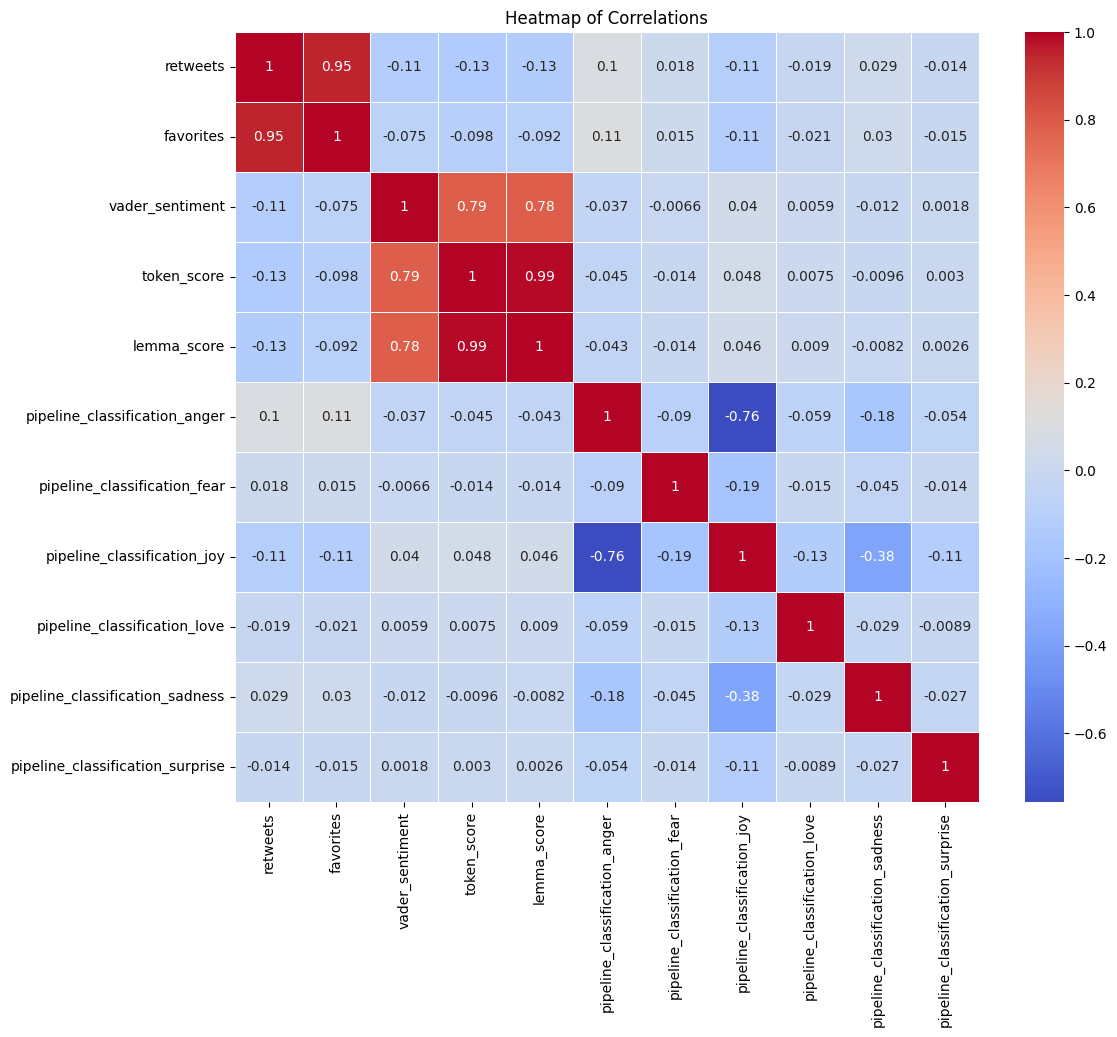

In [59]:
# Select the relevant columns for the heatmap
columns_to_include = ['retweets', 'favorites', 'vader_sentiment', 'token_score', 'lemma_score'] + list(one_hot_encoded_df.columns)
df_heatmap = df_trump_tweets_one_hot[columns_to_include]

# Calculate the correlation matrix
correlation_matrix = df_heatmap.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add titles and labels
plt.title('Heatmap of Correlations')
plt.show()